In [1]:
import numpy as np
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# ----- Data Loading -----
def load_dataset(base_path):
    X, y = [], []
    for label_name, label_val in [('no_fall', 0), ('fall', 1)]:
        folder = os.path.join(base_path, label_name)
        for file in glob(os.path.join(folder, "*.npy")):
            arr = np.load(file)
            if arr.shape == (30, 51):  # Check for correct shape
                X.append(arr)
                y.append(label_val)
    return np.array(X), np.array(y)

# Paths
base_train = '/kaggle/input/fall-dataset4/train'
base_val   = '/kaggle/input/fall-dataset4/val'
base_test  = '/kaggle/input/fall-dataset4/test'

# Load datasets
X_train, y_train = load_dataset(base_train)
X_val,   y_val   = load_dataset(base_val)
X_test,  y_test  = load_dataset(base_test)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

Train: (73147, 30, 51) (73147,)
Val:   (15675, 30, 51) (15675,)
Test:  (15675, 30, 51) (15675,)


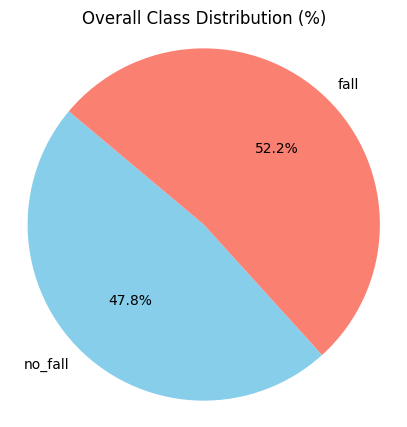

In [3]:
y_all = np.concatenate([y_train, y_val, y_test])
unique, counts = np.unique(y_all, return_counts=True)

# Pie chart
labels = ["no_fall" if l == 0 else "fall" for l in unique]
colors = ["skyblue", "salmon"]
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Overall Class Distribution (%)")
plt.axis("equal")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


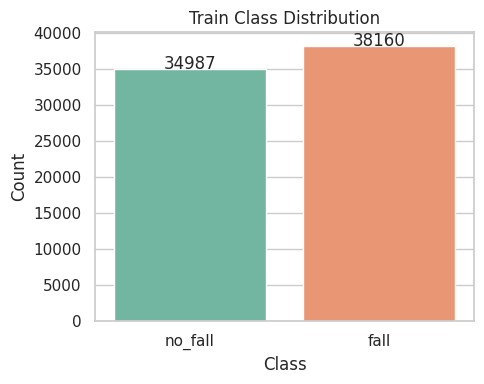

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


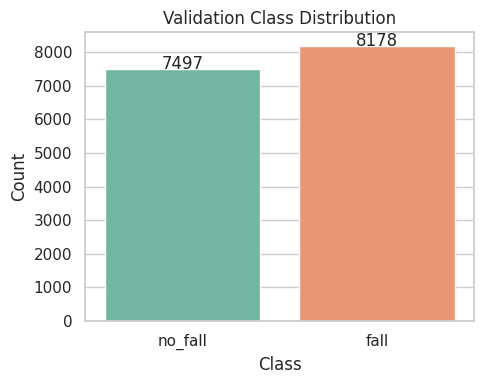

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


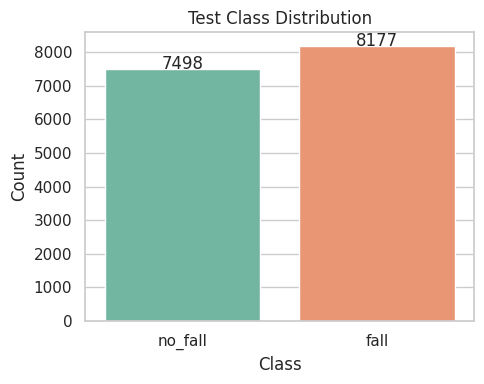

In [4]:
def plot_class_distribution(y_data, dataset_name):
    sns.set(style="whitegrid")
    labels, counts = np.unique(y_data, return_counts=True)
    class_names = ["no_fall" if label == 0 else "fall" for label in labels]
    
    plt.figure(figsize=(5, 4))
    sns.barplot(x=class_names, y=counts, palette="Set2")
    plt.title(f"{dataset_name} Class Distribution")
    plt.ylabel("Count")
    plt.xlabel("Class")
    for i, count in enumerate(counts):
        plt.text(i, count + 1, str(count), ha='center')
    plt.tight_layout()
    plt.show()


plot_class_distribution(y_train, "Train")
plot_class_distribution(y_val, "Validation")
plot_class_distribution(y_test, "Test")


In [5]:
def normalize_sequences(sequences):
    sequences_norm = []
    for seq in sequences:
        seq_norm = np.zeros_like(seq)
        for i in range(17):  # each keypoint
            x = seq[:, i * 3 + 0] / 1920  # normalize x
            y = seq[:, i * 3 + 1] / 1080  # normalize y
            c = seq[:, i * 3 + 2]         # keep confidence as-is
            seq_norm[:, i * 3 + 0] = x
            seq_norm[:, i * 3 + 1] = y
            seq_norm[:, i * 3 + 2] = c
        sequences_norm.append(seq_norm)
    return np.array(sequences_norm)

# Normalize datasets
X_train_norm = normalize_sequences(X_train)
X_val_norm   = normalize_sequences(X_val)
X_test_norm  = normalize_sequences(X_test)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 51)),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
model.summary()

2025-05-10 18:35:20.513849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746902120.744817      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746902120.812071      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-10 18:35:34.467318: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │          29,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,145 (164.63 KB)

 Trainable params: 42,145 (164.63 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Use EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_norm, y_train,
    validation_data=(X_val_norm, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/50
2286/2286 ━━━━━━━━━━━━━━━━━━━━ 61s 24ms/step - accuracy: 0.6343 - loss: 0.6288 - val_accuracy: 0.6586 - val_loss: 0.5905
Epoch 2/50
2286/2286 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step - accuracy: 0.6478 - loss: 0.6012 - val_accuracy: 0.6723 - val_loss: 0.5758
Epoch 3/50
2286/2286 ━━━━━━━━━━━━━━━━━━━━ 56s 24ms/step - accuracy: 0.6543 - loss: 0.5883 - val_accuracy: 0.6776 - val_loss: 0.5658
Epoch 4/50
2286/2286 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step - accuracy: 0.6561 - loss: 0.5827 - val_accuracy: 0.6781 - val_loss: 0.5874
Epoch 5/50
2286/2286 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - accuracy: 0.6587 - loss: 0.5883 - val_accuracy: 0.6820 - val_loss: 0.5510
Epoch 6/50
2286/2286 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step - accuracy: 0.6698 - loss: 0.5617 - val_accuracy: 0.6742 - val_loss: 0.5669
Epoch 7/50
2286/2286 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step - accuracy: 0.6635 - loss: 0.5698 - val_accuracy: 0.6716 - val_loss: 0.5490
Epoch 8/50
2286/2286 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - accuracy: 0.6714 -

In [8]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val_norm, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_norm, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Validation Accuracy: 0.6975
Test Accuracy: 0.6915


490/490 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Validation Report:
               precision    recall  f1-score   support

     no_fall       0.64      0.84      0.73      7497
        fall       0.80      0.57      0.66      8178

    accuracy                           0.70     15675
   macro avg       0.72      0.70      0.69     15675
weighted avg       0.72      0.70      0.69     15675

Test Report:
               precision    recall  f1-score   support

     no_fall       0.63      0.84      0.72      7498
        fall       0.79      0.55      0.65      8177

    accuracy                           0.69     15675
   macro avg       0.71      0.70      0.69     15675
weighted avg       0.72      0.69      0.69     15675


Custom Validation Metrics Report:
         Precision  Recall  F1-score  F2-score  Support
no_fall     0.6396  0.8417    0.7269    0.7917     7497
fall        0.7957  0.5653    0.6610    0.6000     8178

Custom Test Metrics Report

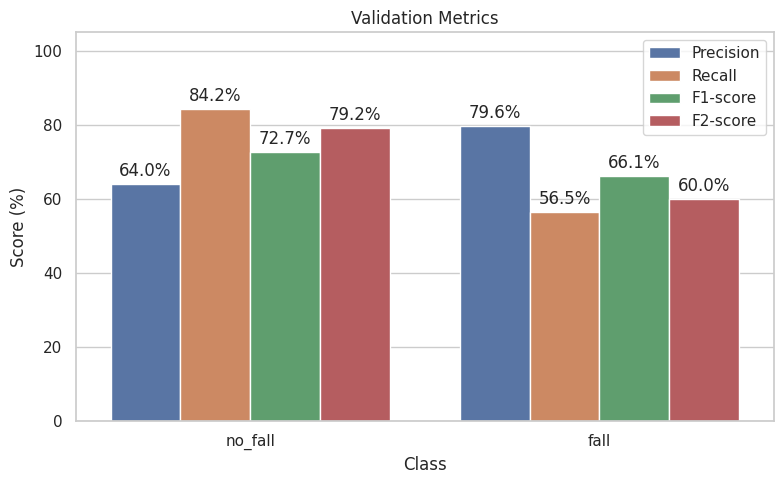

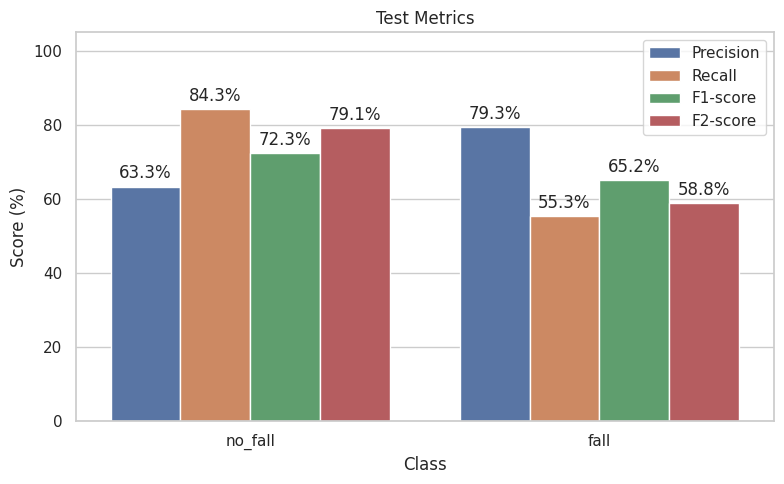

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, fbeta_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

target_names = ['no_fall', 'fall']

# Predict probabilities
y_val_pred_probs = model.predict(X_val_norm)
y_test_pred_probs = model.predict(X_test_norm)

# Convert to class labels (threshold = 0.5)
y_val_pred = (y_val_pred_probs >= 0.5).astype(int)
y_test_pred = (y_test_pred_probs >= 0.5).astype(int)

# Standard classification reports
print("Validation Report:\n", classification_report(y_val, y_val_pred, target_names=target_names))
print("Test Report:\n", classification_report(y_test, y_test_pred, target_names=target_names))

# Custom report function
def get_metrics_report(y_true, y_pred, labels):
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    f2 = fbeta_score(y_true, y_pred, beta=2, average=None)
    support = [sum((y_true == i)) for i in range(len(labels))]
    
    df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'F2-score': f2,
        'Support': support
    }, index=labels)
    
    return df

# Generate DataFrames
val_report_df = get_metrics_report(y_val, y_val_pred, target_names)
test_report_df = get_metrics_report(y_test, y_test_pred, target_names)

# Show DataFrames
print("\nCustom Validation Metrics Report:")
print(val_report_df.round(4))

print("\nCustom Test Metrics Report:")
print(test_report_df.round(4))

# Save to CSV
val_report_df.to_csv("validation_metrics_report.csv")
test_report_df.to_csv("test_metrics_report.csv")
print("\nSaved validation and test metric reports to CSV.")

# Plotting function
def plot_metrics(df, title):
    df_plot = df.drop(columns=['Support']).reset_index()
    df_plot = df_plot.melt(id_vars='index', var_name='Metric', value_name='Score')
    df_plot['Score'] = df_plot['Score'] * 100  # Convert to percent

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=df_plot, x='index', y='Score', hue='Metric')
    plt.title(title)
    plt.ylim(0, 105)
    plt.xlabel("Class")
    plt.ylabel("Score (%)")
    plt.legend(loc='upper right')
    
    # Add labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)
    
    plt.tight_layout()
    plt.show()

# Plot reports
plot_metrics(val_report_df, "Validation Metrics")
plot_metrics(test_report_df, "Test Metrics")


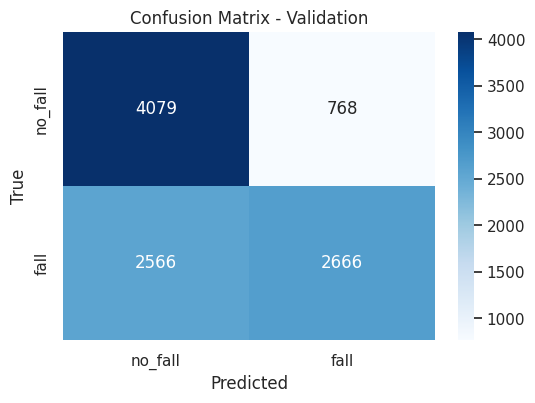

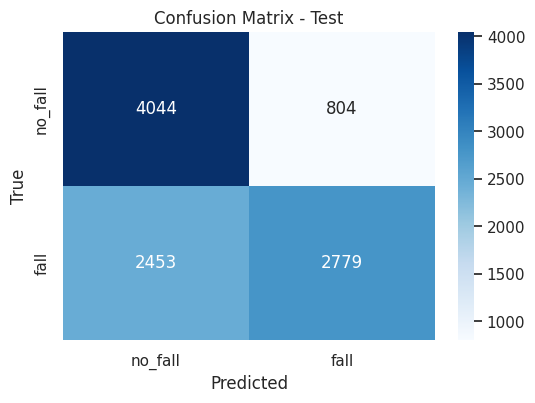

In [10]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no_fall', 'fall'], yticklabels=['no_fall', 'fall'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Confusion matrices
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot
plot_confusion_matrix(cm_val, "Confusion Matrix - Validation")
plot_confusion_matrix(cm_test, "Confusion Matrix - Test")
